In [1]:
from TinySAM import *
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm, trange
from torch.utils.data import DataLoader

# Setting Up Models

In [2]:
GroundingModel = GDino()
SAMModel = SAM2()

# Load Data to RAM

In [3]:
data = ZeroShotObjectDetectionDataset('./Data/cityscapes/',do_preprocess=False, processor=GroundingModel.processor)

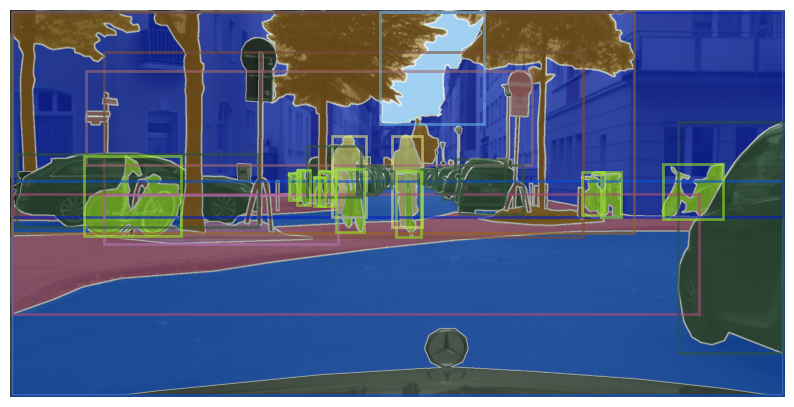

In [4]:
# visualize a random sample
rnd_idx = np.random.randint(0,len(data))
data.visualize(rnd_idx)

# Run Grounding Dino

In [5]:
batch_size = 8
dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)

boxes = []
labels = []
scores = []

# get the text prompts
input_ids = data.input_prompt_ins.input_ids.to(GroundingModel.device)
target_image_size = data.image_size

for batch in tqdm(dataloader):
    outputs = GroundingModel(batch.to(GroundingModel.device), input_ids=input_ids, target_image_size=target_image_size)
    
    for out in outputs:
        boxes.append(out['boxes'].cpu().numpy())
        labels.append(out['labels'])
        scores.append(out['scores'].cpu().numpy())
        for i in range(len(labels[-1])):
            # only pick first label for any dual predictions
            if labels[-1][i] + '.' not in data.text_prompts:
                labels[-1][i] = labels[-1][i].split(' ')[0]

  0%|          | 0/63 [00:00<?, ?it/s]

# Run SAM2

In [6]:
masks = SAMModel(data.images, boxes)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# Save Results (if needed)
# np.save('masks.npy', np.array(masks, dtype=object))
# np.save('boxes.npy', np.array(boxes, dtype=object))
# np.save('labels.npy', np.array(labels, dtype=object))
# np.save('scores.npy', np.array(scores, dtype=object))

In [ ]:
# Load Results (if needed)
# masks = np.load('masks.npy', allow_pickle=True)
# boxes = np.load('boxes.npy', allow_pickle=True)
# labels = np.load('labels.npy', allow_pickle=True)
# scores = np.load('scores.npy', allow_pickle=True)

# Visualize A Prediction

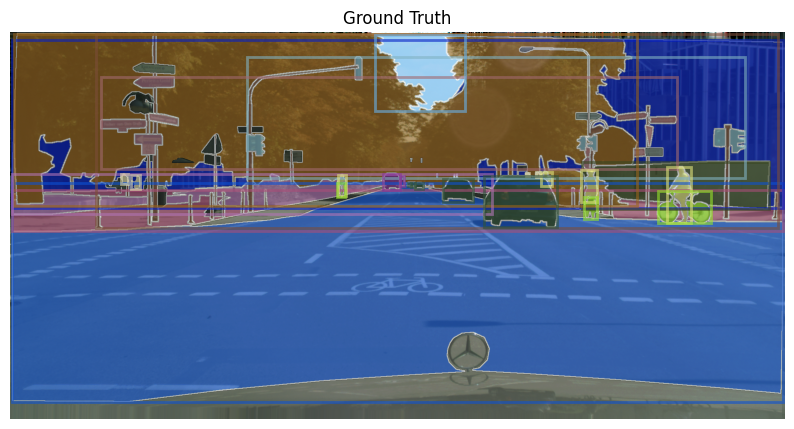

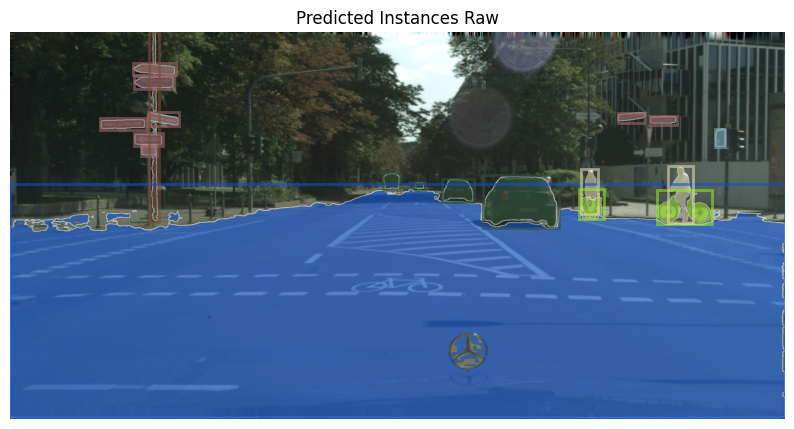

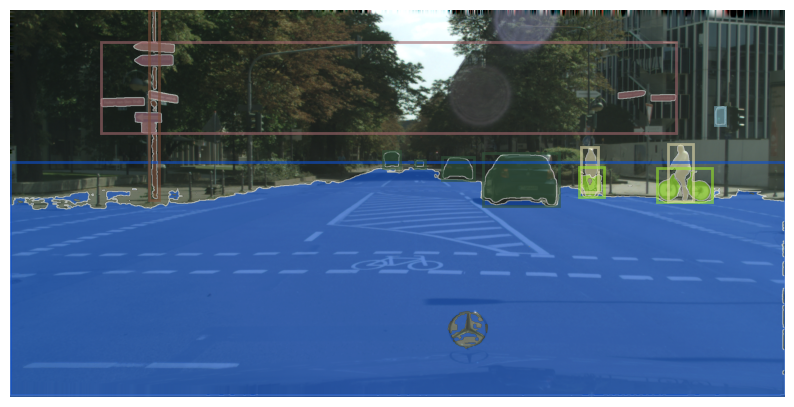

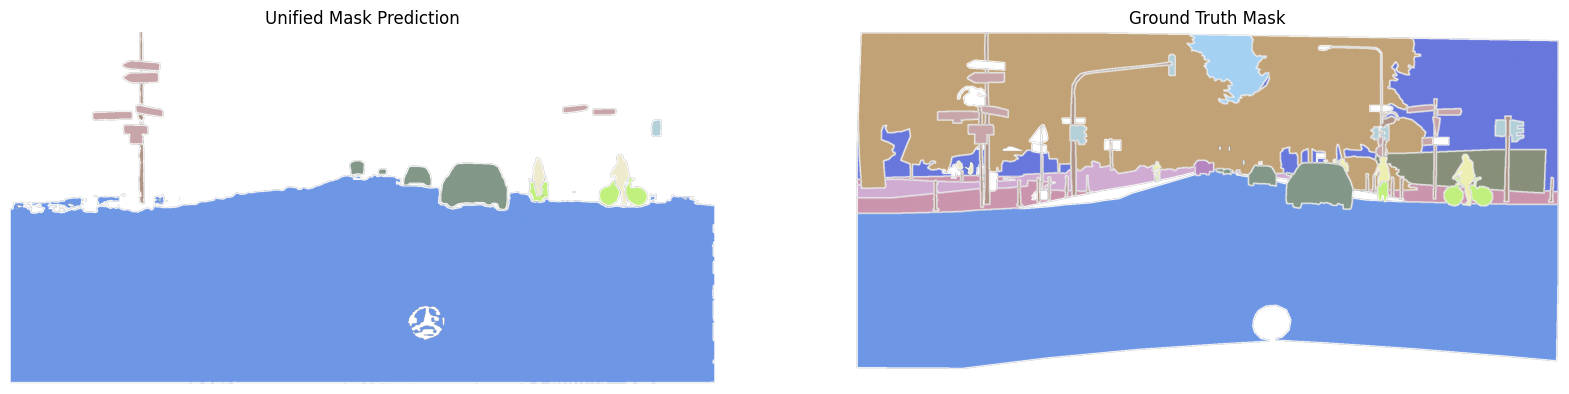

In [8]:
rnd_idx = np.random.randint(0,len(data))
# visualize ground truth
data.visualize(rnd_idx)
plt.title('Ground Truth')

# visualize the predicted masks
data.visualize_prediction(rnd_idx, boxes[rnd_idx], masks[rnd_idx], labels[rnd_idx])
plt.title('Predicted Instances Raw')

# visualize the predicted masks after post-processing
data.visualize_prediction(rnd_idx, boxes[rnd_idx], masks[rnd_idx], labels[rnd_idx], unify=True)

In [9]:
mIoU, mAP = data.evaluate_precitions(boxes, labels, masks, scores)

  0%|          | 0/500 [00:00<?, ?it/s]

Mean IoU:  tensor(0.0752)
Precision Scores:  {'map': tensor(0.2088), 'map_50': tensor(0.2824), 'map_75': tensor(0.2211), 'map_small': tensor(0.0077), 'map_medium': tensor(0.0640), 'map_large': tensor(0.2943), 'mar_1': tensor(0.2041), 'mar_10': tensor(0.2509), 'mar_100': tensor(0.2533), 'mar_small': tensor(0.0086), 'mar_medium': tensor(0.0880), 'mar_large': tensor(0.3548), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19], dtype=torch.int32)}


(tensor(0.0752),
 {'map': tensor(0.2088),
  'map_50': tensor(0.2824),
  'map_75': tensor(0.2211),
  'map_small': tensor(0.0077),
  'map_medium': tensor(0.0640),
  'map_large': tensor(0.2943),
  'mar_1': tensor(0.2041),
  'mar_10': tensor(0.2509),
  'mar_100': tensor(0.2533),
  'mar_small': tensor(0.0086),
  'mar_medium': tensor(0.0880),
  'mar_large': tensor(0.3548),
  'map_per_class': tensor(-1.),
  'mar_100_per_class': tensor(-1.),
  'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
          19], dtype=torch.int32)})